# 1. Reading And Understanding The Data

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras import datasets, models, layers
from keras.preprocessing.image import ImageDataGenerator, img_to_array
import pickle

### Helper Functions

In [23]:
def save_history(history, fn):
        pickle.dump(history.history, open(fn, 'wb'))

def load_history(fn):
    class H():
        pass
    history = H()
    history.history = pickle.load(open(fn, 'rb'))
    return history
    
def plot_history(history):
    
    acc = smooth_curve(history.history['acc'][:-1])
    val_acc = smooth_curve(history.history['val_acc'][:-1])
    loss = smooth_curve(history.history['loss'][:-1])
    val_loss = smooth_curve(history.history['val_loss'][:-1])
    
    plt.figure(figsize=(16, 5))
    plt.style.use('ggplot')
    
    plt.subplot(1,2,1)
    plt.plot(loss, c='red', label='Train Loss')
    plt.plot(val_loss, c='blue', label='Validation Loss')
    plt.title('Train Loss: %.2f, Validation Loss: %.2f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(acc, c='red', label='Train Accuracy')
    plt.plot(val_acc, c='blue', label='Validation Accuracy')
    plt.title('Train Accuracy: %.2f, Validation Accuracy: %.2f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()
    
    plt.show()
    
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

In [24]:
X = np.load('/Sign-language-digits-dataset/X.npy')
Y = np.load('/Sign-language-digits-dataset/Y.npy')

In [25]:
print("Number of data points:", X.shape[0])
print("Number of classes:", Y.shape[1])
print("Image size: {}x{}".format(X.shape[1], X.shape[2]))

Number of data points: 2062
Number of classes: 10
Image size: 64x64


There are 2062 images in the dataset. The size of the images is 64x64. The number of classes is 10 which includes the numbers [0,1,2,3,4,5,6,7,8,9] in sign language. It is a very small dataset for a deep learning algorithm.

In [26]:
print("Data X")
print(X[0])
print("Data Y")
print(Y[0])

Data X
[[0.46666667 0.4745098  0.47843137 ... 0.5176471  0.5137255  0.5019608 ]
 [0.49803922 0.4862745  0.4862745  ... 0.5254902  0.5176471  0.50980395]
 [0.54509807 0.49411765 0.49019608 ... 0.5294118  0.5254902  0.5137255 ]
 ...
 [0.5019608  0.5137255  0.5176471  ... 0.5529412  0.54509807 0.53333336]
 [0.49803922 0.5058824  0.5137255  ... 0.54509807 0.53333336 0.52156866]
 [0.49019608 0.49803922 0.5019608  ... 0.5294118  0.52156866 0.50980395]]
Data Y
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The labels are in the one-hot encoded form. Firstly, I will decode these labels into numerical form.

In [27]:
labels = np.array([np.argmax(Y[i]) for i in range(Y.shape[0])]) # decoding

### Plotting The Dataset

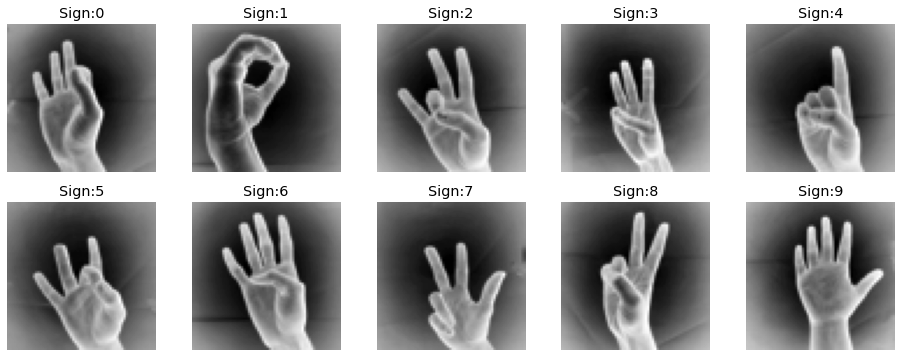

In [28]:
indexes = [0, 204, 409, 615, 822, 1028, 1236, 1443, 1649, 1855]
plt.figure(figsize=(16,6))
for index, item in enumerate(indexes, 1):
    plt.subplot(2,5,index)
    plt.imshow(X[item], cmap=plt.cm.binary)
    plt.title("Sign:" + str(labels[item]))
    plt.axis('off')
plt.show()

Labels are mismatched. For example, it shows sign 0 as a label, but the correct value is 9.

* Sign 1 as a Label = Actual value 0
* Sign 2 as a Label = Actual value 7
* Sign 3 as a Label = Actual value 6
* Sign 4 as a Label = Actual value 1
* Sign 5 as a Label = Actual value 8
* Sign 6 as a Label = Actual value 4
* Sign 7 as a Label = Actual value 3
* Sign 8 as a Label = Actual value 2
* Sign 9 as a Label = Actual value 5

I will match these labels with the correct images.

In [29]:
true_label = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}
true_labels = np.array([true_label[i] for i in labels])

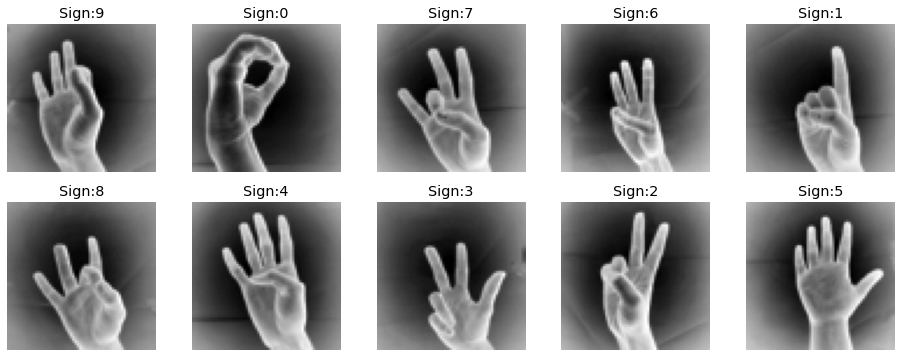

In [30]:
indexes = [0, 204, 409, 615, 822, 1028, 1236, 1443, 1649, 1855]
plt.figure(figsize=(16,6))
for index, item in enumerate(indexes, 1):
    plt.subplot(2,5,index)
    plt.imshow(X[item], cmap=plt.cm.binary)
    plt.title("Sign:" + str(true_labels[item]))
    plt.axis('off')
plt.show()

Labels are matched with their correct images as above.

### Splitting The Dataset

In [31]:
true_labels = true_labels.reshape(X.shape[0],1)
X_train, X_test, y_train, y_test = train_test_split(X, true_labels, test_size=0.20, random_state=42)
X_train = X_train.reshape(-1,64,64,1)
X_test = X_test.reshape(-1,64,64,1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1649, 64, 64, 1)
(413, 64, 64, 1)
(1649, 1)
(413, 1)


# 2. Building a Convolutional Neural Network

### Callbacks

**EarlyStopping:** Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. EarlyStopping method stops training when a monitored metric has stopped improving.
 
During training, the model is evaluated on a holdout validation dataset after each epoch. If the performance of the model on the validation dataset starts to degrade (e.g. loss begins to increase or accuracy begins to decrease), then the training process is stopped.

* patience: Number of epochs with no improvement after which training will be stopped.

In [32]:
earlystop = EarlyStopping(monitor='val_acc', patience=20)

### Training

In [33]:
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3,3), activation="relu",  padding='same', name='conv_1', input_shape=(64, 64, 1)))
model1.add(layers.MaxPooling2D((2,2), name='maxpool_1'))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model1.add(layers.MaxPooling2D((2, 2), name='maxpool_2'))

model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model1.add(layers.MaxPooling2D((2, 2), name='maxpool_3'))

model1.add(layers.Flatten())

model1.add(layers.Dense(256, activation="relu", name='dense_1'))
model1.add(layers.Dense(128, activation="relu", name='dense_2'))
model1.add(layers.Dense(10, activation="softmax", name='output'))
                       
model1.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer="adam")

In [34]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 128)       73856     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [35]:
history_1 = model1.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[earlystop])

Train on 1649 samples, validate on 413 samples
Epoch 1/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 2.0801 - acc: 0.2226 - val_loss: 1.1979 - val_acc: 0.5690
Epoch 2/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.9630 - acc: 0.6671 - val_loss: 0.8276 - val_acc: 0.7409
Epoch 3/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.5464 - acc: 0.8266 - val_loss: 0.4567 - val_acc: 0.8620
Epoch 4/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.3654 - acc: 0.8811 - val_loss: 0.3573 - val_acc: 0.9128
Epoch 5/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.2208 - acc: 0.9297 - val_loss: 0.3622 - val_acc: 0.9007
Epoch 6/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.1409 - acc: 0.9630 - val_loss: 0.2039 - val_acc: 0.9225
Epoch 7/50
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.0914 - acc: 0.9763 - val_loss: 0.2061 - val_acc: 0

In [36]:
train_loss_1, train_accuracy_1 = model1.evaluate(X_train, y_train, verbose=2)
test_loss_1, test_accuracy_1 = model1.evaluate(X_test, y_test, verbose=2)

1649/1649 - 2s - loss: 3.9044e-05 - acc: 1.0000
413/413 - 1s - loss: 0.3119 - acc: 0.9395


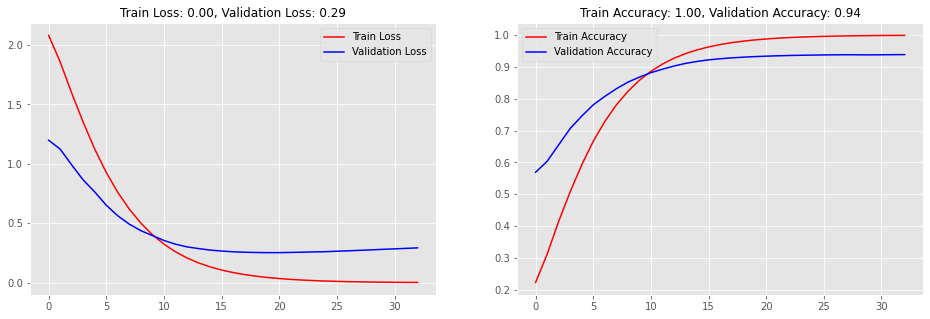

In [37]:
model1.save('model1.h1')
save_history(history_1, 'history_1.bin')
history_1 = load_history('history_1.bin')
plot_history(history_1)

Train accuracy is extremely high, whereas test accuracy is quite lower with 94%. The model is highly overfitting. To prevent overfitting, I will add dropout to the model. Dropout prevents the network to be too dependent on a small number of neurons, and forces every neuron to be able to operate independently.

### Training with Dropout

In [38]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3,3), activation="relu",  padding='same', name='conv_1', input_shape=(64, 64, 1)))
model2.add(layers.MaxPooling2D((2,2), name='maxpool_1'))


model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model2.add(layers.MaxPooling2D((2, 2), name='maxpool_2'))


model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model2.add(layers.MaxPooling2D((2, 2), name='maxpool_3'))


model2.add(layers.Flatten())
model2.add(layers.Dropout(0.50))


model2.add(layers.Dense(256, activation="relu", name='dense_1'))
model2.add(layers.Dense(128, activation="relu", name='dense_2'))
model2.add(layers.Dense(10, activation="softmax", name='output'))
                       
model2.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer="adam")

In [39]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 128)       73856     
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

In [40]:
history_2 = model2.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[earlystop])

Train on 1649 samples, validate on 413 samples
Epoch 1/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 2.2839 - acc: 0.1286 - val_loss: 1.9838 - val_acc: 0.3826
Epoch 2/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 1.2888 - acc: 0.5385 - val_loss: 0.7102 - val_acc: 0.7627
Epoch 3/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.6393 - acc: 0.7884 - val_loss: 0.4019 - val_acc: 0.8789
Epoch 4/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.4391 - acc: 0.8526 - val_loss: 0.3271 - val_acc: 0.8886
Epoch 5/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.2992 - acc: 0.9030 - val_loss: 0.2527 - val_acc: 0.9080
Epoch 6/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.2387 - acc: 0.9200 - val_loss: 0.2550 - val_acc: 0.8935
Epoch 7/100
1649/1649 [==============================] - 10s 6ms/sample - loss: 0.2066 - acc: 0.9309 - val_loss: 0.2443 - val

In [41]:
train_loss_2, train_accuracy_2 = model2.evaluate(X_train, y_train, verbose=2)
test_loss_2, test_accuracy_2 = model2.evaluate(X_test, y_test, verbose=2)

1649/1649 - 2s - loss: 9.0994e-04 - acc: 1.0000
413/413 - 1s - loss: 0.1773 - acc: 0.9637


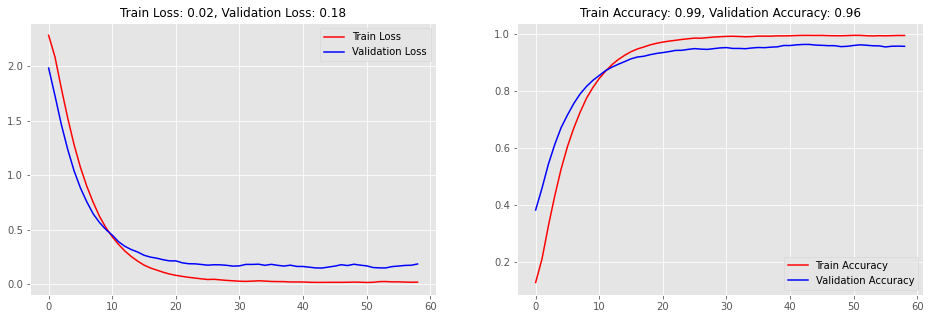

In [42]:
model2.save('model2.h2')
save_history(history_2, 'history_2.bin')
history_2 = load_history('history_2.bin')
plot_history(history_2)

### Training with Data Augmentation

Although the model generalizes better on the test set, the model is still overfitting. Since the dataset is very small, the accuracy can be increased with data augmentation. It increases the training data by generating new examples via random transformation of existing ones such as rotation, shifting, or resizing. This way we artificially boost the size of the training set and reduce overfitting.

In [45]:
datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

datagen.fit(X_train)

train_generator = datagen.flow(
    X_train,
    y_train, 
    batch_size=32
)

validation_generator = datagen.flow(
    X_test,
    y_test, 
    batch_size=32
)

### Generator Example

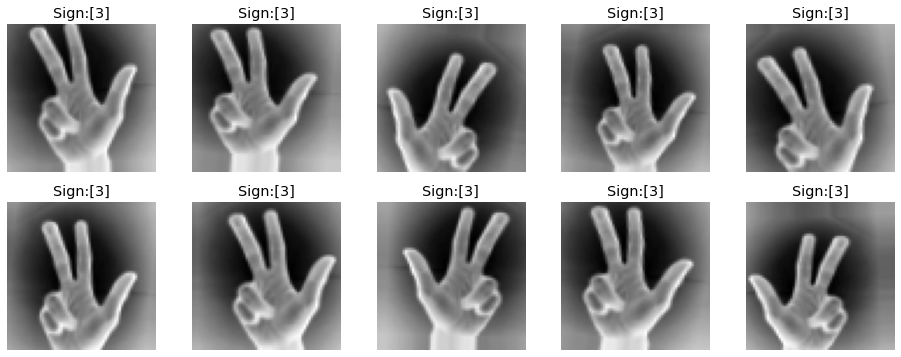

In [46]:
image = img_to_array(X_train[10])
image = image.reshape((1,) + image.shape)

datagenerator = datagen.flow(image)

i = 0 
plt.figure(figsize=(16,6))
for index, batch in enumerate(datagenerator, 1):
    plt.subplot(2,5,index)
    plt.imshow(img_to_array(batch[0]), cmap=plt.cm.binary)
    plt.title("Sign:" + str(y_train[10]))
    plt.axis('off')
    i += 1
    if i > 9: break
plt.show()

In [47]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3,3), activation="relu",  padding='same', name='conv_1', input_shape=(64, 64, 1)))
model3.add(layers.MaxPooling2D((2,2), name='maxpool_1'))


model3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model3.add(layers.MaxPooling2D((2, 2), name='maxpool_2'))

model3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model3.add(layers.MaxPooling2D((2, 2), name='maxpool_3'))

model3.add(layers.Flatten())
model3.add(layers.Dropout(0.50))


model3.add(layers.Dense(256, activation="relu", name='dense_1'))
model3.add(layers.Dense(128, activation="relu", name='dense_2'))
model3.add(layers.Dense(10, activation="softmax", name='output'))
                       
model3.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer="adam")

In [48]:
history_3 = model3.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)/32, 
    epochs=100,
    validation_data=validation_generator,
    callbacks=[earlystop]
)

Epoch 1/100
52/51 [==============================] - 12s 230ms/step - loss: 2.3082 - acc: 0.0885 - val_loss: 2.3037 - val_acc: 0.0920
Epoch 2/100
52/51 [==============================] - 11s 205ms/step - loss: 2.3025 - acc: 0.1013 - val_loss: 2.3009 - val_acc: 0.1041
Epoch 3/100
52/51 [==============================] - 10s 200ms/step - loss: 2.1691 - acc: 0.1971 - val_loss: 2.0435 - val_acc: 0.2760
Epoch 4/100
52/51 [==============================] - 10s 200ms/step - loss: 1.7040 - acc: 0.3930 - val_loss: 1.5489 - val_acc: 0.4625
Epoch 5/100
52/51 [==============================] - 11s 211ms/step - loss: 1.4216 - acc: 0.4955 - val_loss: 1.1799 - val_acc: 0.5884
Epoch 6/100
52/51 [==============================] - 11s 216ms/step - loss: 1.1863 - acc: 0.5907 - val_loss: 1.0112 - val_acc: 0.6247
Epoch 7/100
52/51 [==============================] - 12s 224ms/step - loss: 0.9860 - acc: 0.6477 - val_loss: 0.9193 - val_acc: 0.6828
Epoch 8/100
52/51 [==============================] - 11s 220ms

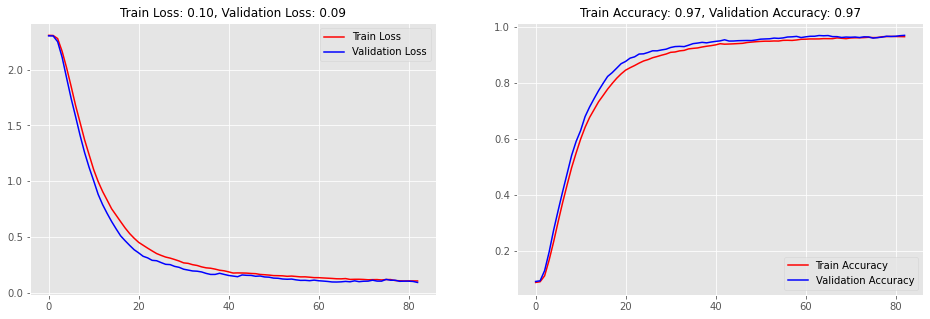

In [49]:
model3.save('model3.h3')
save_history(history_3, 'history_3.bin')
history_3 = load_history('history_3.bin')
plot_history(history_3)

The model generalizes pretty well with data augmentation. Train accuracy and test accuracy are both reached 97%.

# 3. Visualizing Feature Maps

I will visualize the feature maps to show input transformation while convolution filters are passing through the convolution layers. 

In [55]:
output_layers = [layer.output for layer in model3.layers[0:6]]
intermediate_layer_model = models.Model(inputs=model3.inputs, outputs=output_layers)

In [58]:
all_layers = intermediate_layer_model.predict(validation_generator[5])
first_layer  = all_layers[0]
print(first_layer.shape)

(32, 64, 64, 32)


The following figure displays 32 feature maps per layer. The layers contain 32, 64, 128 feature maps in sequence since there are 32, 64, 128 filters in these layers. I will only visualize the first 32 feature maps per layer.

There are some dark and bright areas in these feature maps. Bright areas show that the filter detects the pattern in this region.

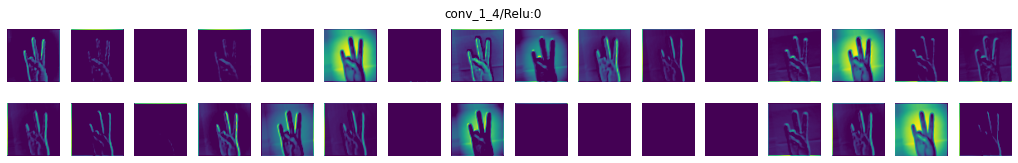

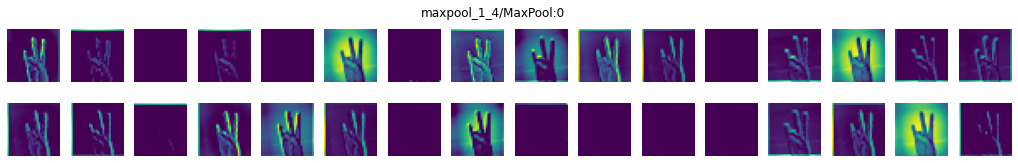

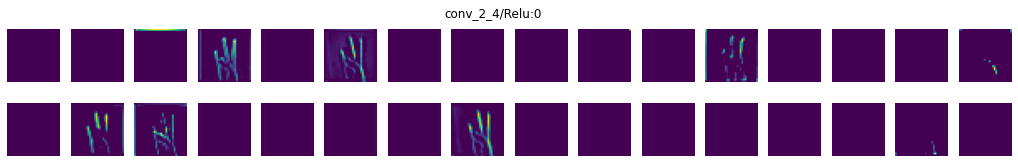

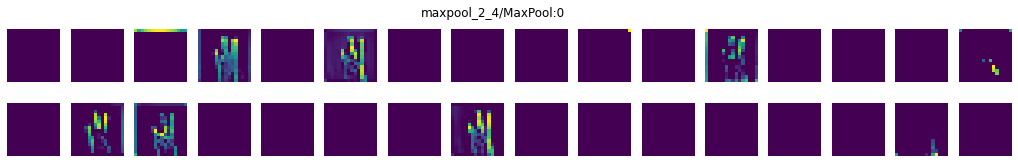

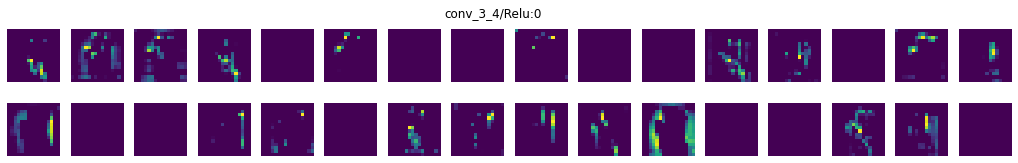

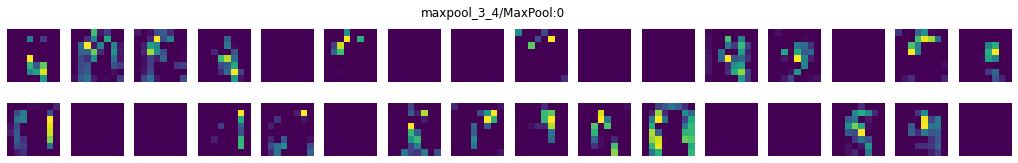

In [61]:
for i in range(6):
    plt.figure(figsize=(18,2.5))
    plt.suptitle(output_layers[i].name)
    for j in range(32):
        plt.subplot(2,16,j+1)
        plt.imshow(all_layers[i][0,:,:,j])
        plt.axis("off") 
    plt.show()

* The first few layers retain most of the information from the image. These low-level feature maps detect simple edges and shapes.
* As we go into the deeper layers, the activations are more abstract. These layers try to catch high-level features such as corners or angles.
* In the last few layers, We can't make a visual interpretation, because these layers detect more complex features. They actually contain information about the class of the image.